In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import telegram
import pandahouse
from datetime import date
import io
from read_db.CH import Getch
import sys
import os

### Задание 1

In [123]:
# take cohort for the last 2 months
df1 = Getch('''select start_day, day, source, uniqExact(user_id) as users
    from (
    select *
    from 
    (select 
        user_id,
        source,
        min(toDate(time)) as start_day
    from simulator_20211220.feed_actions
    group by user_id, source
    having start_day >= today()-60) as t1
    join (
    select
        distinct user_id,
        toDate(time) as day
    from simulator_20211220.feed_actions) as t2
    using user_id)
    group by start_day, day, source
    order by start_day, day, source''').df

df1

,start_day,day,source,users
0,2021-11-27,2021-11-27,ads,1263
1,2021-11-27,2021-11-27,organic,1114
2,2021-11-27,2021-11-28,ads,585
3,2021-11-27,2021-11-28,organic,628
4,2021-11-27,2021-11-29,ads,546
...,...,...,...,...
3777,2022-01-25,2022-01-25,organic,69
3778,2022-01-25,2022-01-26,ads,261
3779,2022-01-25,2022-01-26,organic,9
3780,2022-01-26,2022-01-26,ads,643


In [124]:
# find percentage of retention for each day
cohorts = df1.merge(df1[df1.day==df1.start_day][['start_day','source', 'users']], how='inner', on=['start_day', 'source'])
cohorts['day'] = cohorts.groupby(['start_day','source']).cumcount()+1
cohorts['perc']= round(cohorts.users_x / cohorts.users_y,2)
# find mean percentage for each day
cohorts = cohorts.groupby(['day','source']).agg({'perc':'mean'}).reset_index()
cohorts

,day,source,perc
0,1,ads,1.000000
1,1,organic,1.000000
2,2,ads,0.356000
3,2,organic,0.404167
4,3,ads,0.331525
...,...,...,...
117,59,organic,0.163333
118,60,ads,0.090000
119,60,organic,0.145000
120,61,ads,0.090000


[(0.0, 1.046469696969697)]

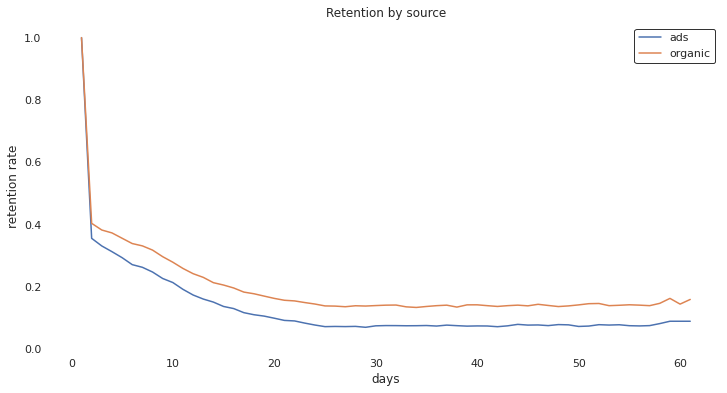

In [125]:
sns.set(rc={'figure.figsize': (12, 6)}) 
plt.tight_layout()

ax = sns.lineplot( 
    x=cohorts['day'], 
    y=cohorts['perc'],
    hue=cohorts['source']
    )

        
ax.set(xlabel='days')
ax.set(ylabel='retention rate') 
ax.set_facecolor('white')
ax.grid(True)
ax.legend(edgecolor=(0, 0, 0, 1.), facecolor=(1, 1, 1, 0.1))


ax.set_title('Retention by source') 
ax.set(ylim=(0, None))

Вывод \
В среднем за последние 2 месяца пользователи, пришедшие с органики, вовлечены в продукт сильнее, чем пользователи с рекламы, и в среднем возвращаются чаще.

### Задание 2

In [126]:
df2 = Getch('''select 
        toDate(time) as day,
        count(distinct user_id) as users
    from simulator_20211220.feed_actions
    where user_id in (
        select user_id
        from simulator_20211220.feed_actions
        where source='ads'
        group by user_id
        having min(toDate(time))='2021-12-28')
    group by toDate(time)''').df

In [127]:
df2['perc'] = round(df2['users'] / df2['users'].max(), 2)

[(0.0, 1.0495)]

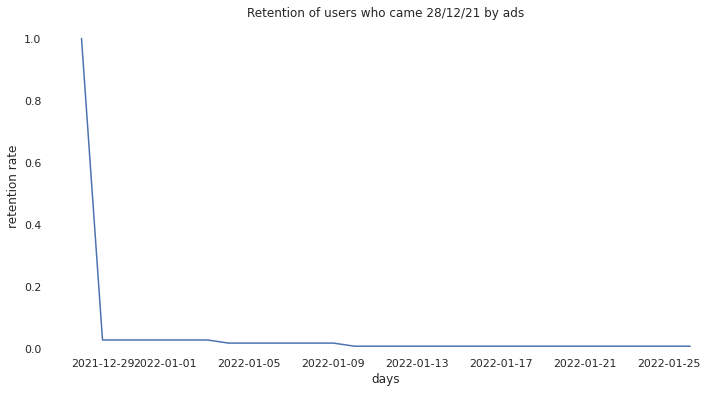

In [129]:
sns.set(rc={'figure.figsize': (12, 6)}) 
plt.tight_layout()

ax = sns.lineplot( 
    x=df2['day'], 
    y=df2['perc']
    )

        
ax.set(xlabel='days')
ax.set(ylabel='retention rate') 
ax.set_facecolor('white')
ax.grid(True)


ax.set_title('Retention of users who came 28/12/21 by ads') 
ax.set(ylim=(0, None))

Вывод \
Retention юзеров, пришедших после рекламной кампании 28 декабря, очень низкий. Пользователи посетили приложение, но дальше практически не использовали его. Нужно пересмотреть подход к рекламе приложения.

### Задание 3

In [130]:
df31 = Getch('''select 
        toDate(time) as day,
        source,
        gender,
        country,
        os,
        count(distinct user_id) as users
    from simulator_20211220.feed_actions
    group by toDate(time), source, gender,
        country,
        os
    order by toDate(time), source''').df

df31

,day,source,gender,country,os,users
0,2021-11-18,ads,1,Kazakhstan,Android,1
1,2021-11-18,ads,0,Turkey,Android,5
2,2021-11-18,ads,0,Russia,iOS,86
3,2021-11-18,ads,1,Azerbaijan,iOS,2
4,2021-11-18,ads,0,Russia,Android,176
...,...,...,...,...,...,...
5620,2022-01-26,organic,1,Finland,Android,18
5621,2022-01-26,organic,1,Kazakhstan,iOS,34
5622,2022-01-26,organic,1,Cyprus,iOS,2
5623,2022-01-26,organic,1,Finland,iOS,20


Посмотрим DAU в различных разрезах

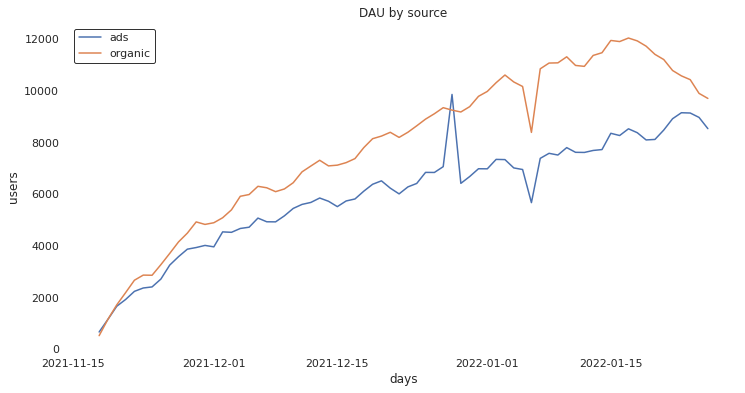

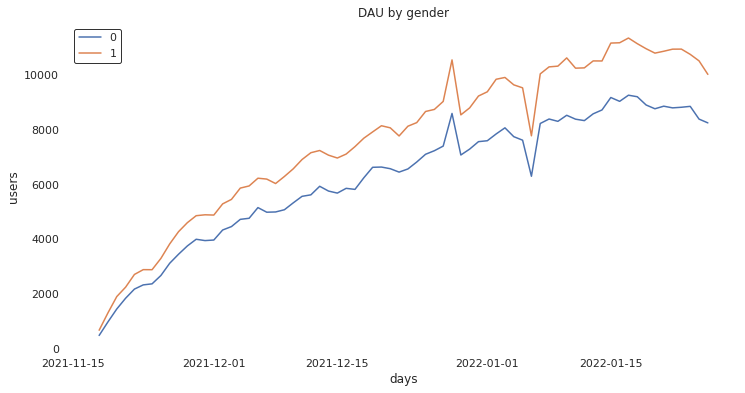

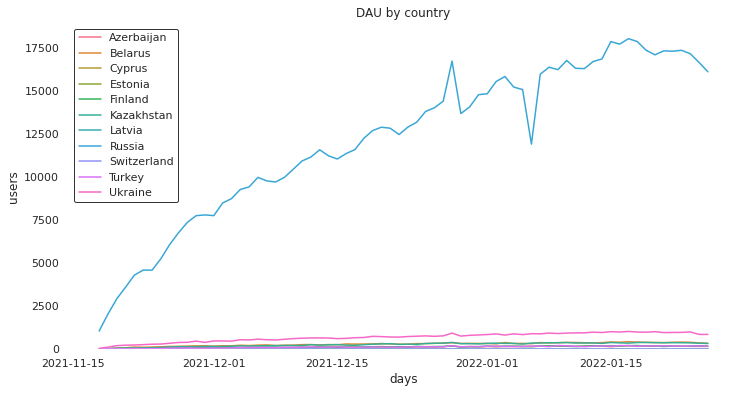

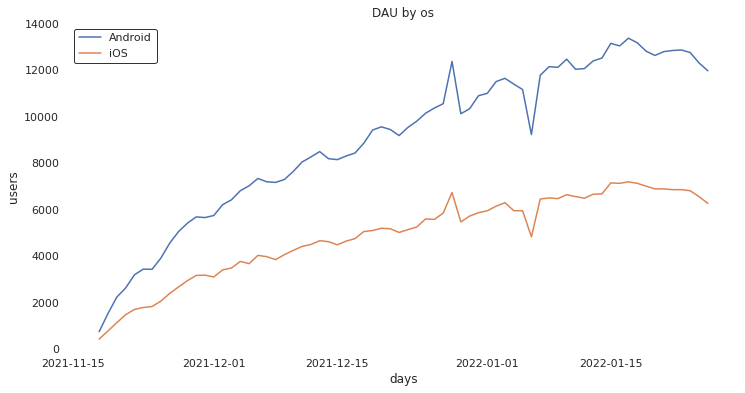

In [131]:
for group in ['source','gender', 'country', 'os']:
    sns.set(rc={'figure.figsize': (12, 6)}) 
    plt.tight_layout()

    ax = sns.lineplot( 
        x=df31.groupby(['day',group]).agg({'users':'sum'}).reset_index()['day'], 
        y=df31.groupby(['day',group]).agg({'users':'sum'}).reset_index()['users'],
        hue=df31.groupby(['day',group]).agg({'users':'sum'}).reset_index()[group]
        )


    ax.set(xlabel='days')
    ax.set(ylabel='users') 
    ax.set_facecolor('white')
    ax.grid(True)
    ax.legend(edgecolor=(0, 0, 0, 1.), facecolor=(1, 1, 1, 0.1))


    ax.set_title('DAU by ' + group) 
    ax.set(ylim=(0, None))
    
    plt.show()

In [132]:
df32 = Getch('''select 
        city,
        uniqExactIf(user_id, toDate(time)='2022-01-06') as users_060122,
        uniqExactIf(user_id, toDate(time)='2022-01-05') as users_050122,
        uniqExactIf(user_id, toDate(time)='2022-01-07') as users_070122
    from simulator_20211220.feed_actions
    group by city''').df

df32

,city,users_060122,users_050122,users_070122
0,Argayash,2,0,1
1,Gubakha,1,1,1
2,Aniskino,4,2,2
3,Zinkiv,1,1,0
4,Dylym,1,0,2
...,...,...,...,...
3743,Aleksandrovsk-Sakhalinskiy,1,2,2
3744,Petropavlivs’ka Borshchahivka,1,0,0
3745,Vuisternens-devant-Romont,0,0,0
3746,Jyväskylän Maalaiskunta,0,1,2


In [133]:
# df32.sort_values(by='users_060122', ascending=True)
df32.sort_values(by='users_050122', ascending=False)[:10]

,city,users_060122,users_050122,users_070122
1772,Moscow,0,2319,2492
2226,Saint Petersburg,0,764,732
3252,Novosibirsk,0,213,242
2329,Yekaterinburg,0,210,205
3235,Chelyabinsk,155,195,202
1274,Rostov,159,176,159
319,Kazan,154,167,162
2969,Nizhniy Novgorod,182,167,181
1173,Samara,181,160,159
256,Voronezh,154,149,137


Вывод \
Пользователи, которые не смогли зайти в приложение 6 января, из Москвы, Спб, Новосиба и Екб

 [Дальше не к заданию, но просто было интересно]

In [134]:
df33 = Getch('''select start_day, day, uniqExact(user_id) as users
from (
select *
from 
(select 
    user_id,
    min(toDate(time)) as start_day
from simulator_20211220.feed_actions
group by user_id
having start_day between '2022-01-01' and '2022-01-06') as t1
join (
select
    distinct user_id,
    toDate(time) as day
from simulator_20211220.feed_actions) as t2
using user_id)
group by start_day, day
order by start_day, day''').df

df33

,start_day,day,users
0,2022-01-01,2022-01-01,2502
1,2022-01-01,2022-01-02,1241
2,2022-01-01,2022-01-03,1120
3,2022-01-01,2022-01-04,1082
4,2022-01-01,2022-01-05,1077
...,...,...,...
136,2022-01-06,2022-01-22,203
137,2022-01-06,2022-01-23,249
138,2022-01-06,2022-01-24,229
139,2022-01-06,2022-01-25,217


In [135]:
# find percentage of retention for each day
cohorts = df33.merge(df33[df33.day==df33.start_day][['start_day','users']], how='inner', on='start_day')
cohorts['day_num'] = cohorts.groupby('start_day').cumcount()+1
cohorts['perc']= round(cohorts.users_x / cohorts.users_y,2)
cohorts = cohorts.pivot_table('perc', 'start_day', 'day_num')
cohorts

day_num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
start_day,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01,1.0,0.50,0.45,0.43,0.43,0.31,0.38,0.36,0.33,0.30,0.27,0.26,0.24,0.22,0.22,0.20,0.20,0.18,0.17,0.17,0.16,0.15,0.15,0.14,0.13,0.12
2022-01-02,1.0,0.44,0.41,0.39,0.30,0.36,0.34,0.33,0.29,0.26,0.26,0.23,0.22,0.21,0.19,0.19,0.16,0.17,0.16,0.15,0.13,0.16,0.14,0.12,0.12,NaN
2022-01-03,1.0,0.47,0.43,0.33,0.39,0.38,0.34,0.33,0.30,0.30,0.27,0.24,0.23,0.21,0.21,0.18,0.18,0.16,0.17,0.16,0.15,0.14,0.14,0.12,NaN,NaN
2022-01-04,1.0,0.29,0.22,0.29,0.25,0.25,0.24,0.25,0.21,0.17,0.17,0.17,0.16,0.15,0.13,0.12,0.13,0.12,0.11,0.10,0.10,0.10,0.09,NaN,NaN,NaN
2022-01-05,1.0,0.21,0.27,0.22,0.21,0.21,0.19,0.20,0.18,0.16,0.19,0.14,0.11,0.11,0.11,0.13,0.10,0.10,0.08,0.10,0.08,0.10,NaN,NaN,NaN,NaN
2022-01-06,1.0,0.39,0.34,0.34,0.31,0.29,0.29,0.30,0.26,0.24,0.22,0.22,0.18,0.19,0.18,0.16,0.12,0.15,0.14,0.13,0.12,NaN,NaN,NaN,NaN,NaN


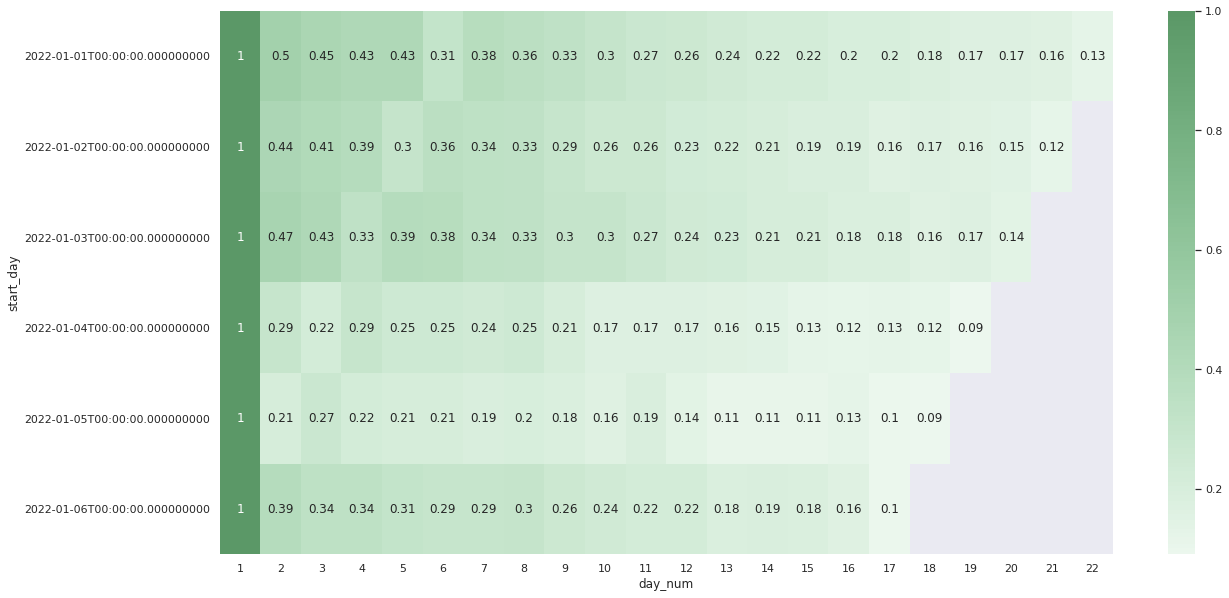

In [136]:
sns.set(rc={'figure.figsize': (20, 10)}) 
sns.heatmap(t, cmap=sns.cubehelix_palette(start=2, rot=0, dark=0.5, light=.95, reverse=False, as_cmap=True), annot=True)
plt.show()
